# Script de récupération des annotions

In [1]:
import os
import numpy as np
from lxml import etree

labels = os.listdir('train/labels')
for lbl in labels:
    root = etree.parse(os.path.join('train/labels', lbl))
    objs = root.findall("object")
    bndboxes = np.zeros((len(objs), 5))
    for idx, obj in enumerate(objs):
        d = int(obj.find("difficult").text)
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        i = ymin
        j = xmin
        h = ymax - ymin
        w = xmax - xmin
        bndboxes[idx, :] = np.array([i, j, h, w, d])
    np.savetxt(os.path.join('labels_csv', lbl[:-4] + '.csv'), bndboxes, fmt='%i', delimiter=",")


In [1]:
import glob
import numpy as np
from skimage import io
import csv
import matplotlib.pyplot as plt
import os
from skimage.transform import resize

In [4]:
from skimage.feature import hog
from skimage.color import rgb2gray
path = "train\images\pos\eco_pos"
img = io.imread(os.path.join(path,'amiotnoe_pos_009_pos0.jpg'))
I = hog(rgb2gray(img))
print(I.shape[0])

1296


##fonction permettant de récupérer tous les exemples positifs

In [2]:
for img in glob.glob("train\images\pos\*.jpg"):
    file = os.path.join('labels_csv',img[17:][:-4]+'.csv')
    if os.path.exists(file):
        csv_file = np.genfromtxt(file, delimiter=',')
        csv_file = csv_file.astype("int")
        if len(csv_file.shape) == 1 :
            csv_file = np.expand_dims(csv_file, axis = 0)
        num = 0
        for row in range(csv_file.shape[0]):
            i = csv_file[row,0]
            j = csv_file[row,1]
            h = csv_file[row,2]
            l = csv_file[row,3]
            d = csv_file[row,4]
            image = io.imread(img)
            exemple_pos = image[i:i+h+1,j:j+l+1,:]
            exemple_pos = resize(exemple_pos, (50, 50), anti_aliasing=True) 
            plt.imsave(os.path.join('train\images\pos\eco_pos',img[17:][:-4]+'_pos'+str(num)+'.jpg'), exemple_pos)
            num = num + 1

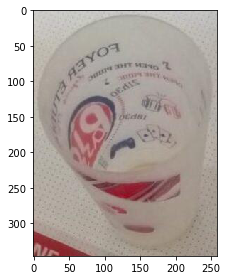

In [35]:
path = "train\images\pos\eco_pos"
img = io.imread(os.path.join(path,'amiotnoe_pos_009_pos0.jpg'))
io.imshow(img)

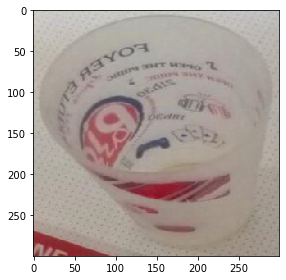

In [38]:
io.imshow(resize(img, (300, 300), anti_aliasing=True))

# Fonction pour récupérer des exemples positifs pivotés

In [3]:
for img in glob.glob("train\images\pos\eco_pos\*.jpg"):
    image = io.imread(img)
    imageflipr = np.fliplr(image)
    imageflipud = np.flipud(image)
    plt.imsave(os.path.join('train\images\pos\eco_pos',img[25:][:-4] + '_flipr' +'.jpg'), imageflipr)
    plt.imsave(os.path.join('train\images\pos\eco_pos',img[25:][:-4] + '_flipud' +'.jpg'), imageflipud)

# Fonction de récupération des exemples négatifs dans les photos négatives

In [4]:
import random
for img in glob.glob("train/images/neg/*.jpg"):
    image = io.imread(img)
    for ite in range(10):
        h = 1
        l = 100
        while (min(h,l)/max(h,l)) < (1/5):
            h = random.randint(20,image.shape[0]-1)
            l = random.randint(20,image.shape[1]-1)
        i = random.randint(0,image.shape[0]-1-h)
        j = random.randint(0,image.shape[1]-1-l)
        exemple_neg = image[i:i+h+1,j:j+l+1,:]
        exemple_neg = resize(exemple_neg, (50, 50), anti_aliasing=True)
        plt.imsave(os.path.join('train/images/neg/eco_neg',img[17:][:-4]+'_neg'+str(ite)+'.jpg'), exemple_neg)

In [23]:
import random
import numpy as np
from skimage import io
import csv
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
import glob

for img in glob.glob("train/images/neg/eco_neg/*.jpg"):
        image = io.imread(img)
        image = resize(image, (300, 300), anti_aliasing=True)
        plt.imsave(img, image)

# Fonction de fenêtre glissante pour la détection

In [95]:
from skimage.filters import sobel
from skimage.color import label2rgb, rgb2gray

def texture_non_plane(img):
    '''fonction retournant si la matrice étudié est une texture plane grâce au filtre de sobel'''
    edges = sobel(rgb2gray(img))
    return (np.max(edges) > 0.2)



def fenetre_glissante(img, liste):
    pos_result = []  
    h = (img.shape[1]+1)//8
    l = (img.shape[0]+1)//8
    print(img.shape)
    for inter in range(5):
        for i in range(0,2*(img.shape[1]+1)//h):
            for j in range(0,2*(img.shape[0]+1)//l):
                coin_i = h*i//2
                coin_j = l*j//2
                fenetre = img[coin_j:(coin_j + l), coin_i:(coin_i + h)]
                liste.append(fenetre)
                if (predict(fenetre) == 1):
                    pos_result.append([coin_i*(inter+1), coin_j*(inter+1), h*(inter+1), l*(inter+1)])
        img = resize(img, (img.shape[0]//2, img.shape[1]//2), anti_aliasing=True)
#essayer avec findcontour et drawcontour

In [92]:
path = "train\images"
img = io.imread(os.path.join(path,'image-attractive.jpg'))
img = rgb2gray(img)
liste = []
print(img.shape[0]//8, img.shape[1]//8)
fenetre_glissante(img, liste)
print(len(liste))

92 160
(743, 1280)
(371, 640)
(185, 320)
(92, 160)
(46, 80)
(23, 40)
341


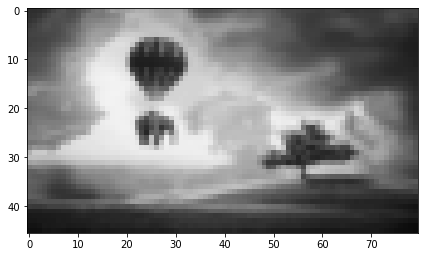

In [93]:
io.imshow(liste[340])

# Programme pour entraîner notre classifieur

In [2]:
import numpy as np
from skimage import io
import csv
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
import glob
from sklearn import svm
from skimage.feature import hog
from skimage.color import rgb2gray

path = "train\images\pos\eco_pos"
img = io.imread(os.path.join(path,'amiotnoe_pos_009_pos0.jpg'))
I = hog(rgb2gray(img))
print(I.shape[0])

X_train = np.zeros((300, I.shape[0]))
i=0
taille_doss=5670

for img in glob.glob("train/images/pos/eco_pos/*.jpg"):
    image = io.imread(img)
    I = hog(rgb2gray(image))
    X_train[i,:]=I
    i = i + 1
    
nb_pos = i
    
for img in glob.glob("train/images/neg/eco_neg/*.jpg"):
    image = io.imread(img)
    I = hog(rgb2gray(image))
    X_train[i,:]=I
    i = i + 1
    
nb_neg = i - nb_pos

y_train = np.zeros(i)

for j in range(nb_pos):
    y_train[j] = 1
    
for j in range(nb_pos, i, 1):
    y_train[j] = -1
    
print()
    
clf = svm.SVC()
clf.fit(X_train, y_train)

99225



SVC()

In [6]:
path = "train\images\pos\eco_pos"
img = io.imread(os.path.join(path,'amiotnoe_pos_006_pos0.jpg'))
I = hog(rgb2gray(img))

clf.predict([I])

array([1.])